In [2]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show

import glob
import pystac_client
import planetary_computer
import geopandas as gpd
import stackstac
import rasterio
from rasterio.merge import merge
import glob
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from rasterio import mask
from rasterio import plot
import shapely
import time
import json
import os

In [3]:
import src.height_estimation as he

In [4]:
def getFeatures(gdf): #used
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [39]:
def write_raster(raster, img, transform, count, path):
    out_meta = raster.meta
    out_meta.update({"driver": "GTiff", "height": img.shape[1],
                     "width": img.shape[2], "transform": transform,
                    "count": count})
    with rasterio.open(path, "w", **out_meta) as dest:
        dest.write(img)

In [6]:
collection="3dep-lidar-hag" 
all_tiles_dir="/hpc/group/borsuklab/ast/tiles"
tif_name = 'm_3009354_sw_15_060_20190905.tif'

catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                                    modifier = planetary_computer.sign_inplace,)

#create utm geometry
#minx, miny, maxx, maxy = row[['nw_x_utm_object_coord','se_y_utm_object_coord',
#                              'se_x_utm_object_coord','nw_y_utm_object_coord']]
tank_geometry_latlon = shapely.geometry.box(-93.3446, 30.158, -93.315665, 30.186935, ccw=True) #utm
#search catalog using lat lon geometry
item_collection = catalog.search(collections=[collection], 
                        intersects=tank_geometry_latlon).item_collection()


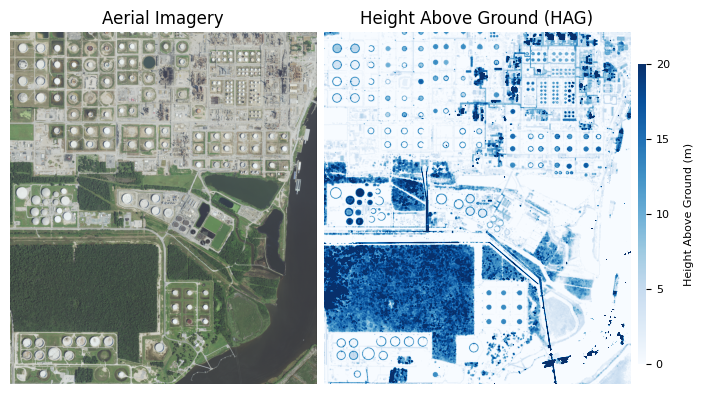

In [42]:
tank_geometry_utm = shapely.geometry.box(467_000.0, 3_336_342.0, 469_400.0, 3_339_100.0, ccw=True) #u

tif_raster = rasterio.open(os.path.join(all_tiles_dir, tif_name))
geo = gpd.GeoDataFrame({'geometry': tank_geometry_utm}, index=[0], crs=tif_raster.crs)     
tif_img, tif_transform  = rasterio.mask.mask(dataset=tif_raster, shapes=getFeatures(geo), crop=True) #nodata=nodata_value, 

hag_raster = rasterio.open(item_collection[0].assets["data"].href)#.read().squeeze()
hag_img, hag_transform  = rasterio.mask.mask(dataset=hag_raster, shapes=getFeatures(geo), crop=True) #nodata=nodata_value, 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
rasterio.plot.show(tif_img[:3].squeeze(), transform=tif_transform, ax=axes[0], zorder=0) 
axes[0].set_axis_off()
axes[0].set_title(f"Aerial Imagery",fontsize=12)
#axes[0].set_aspect("equal")
axes[0].set_aspect('equal', 'box')

axes[1].imshow(hag_img.squeeze(), cmap="Blues", vmin=0, vmax=20)
axes[1].set_axis_off()
axes[1].set_title(f"Height Above Ground (HAG)",fontsize=12)
#axes[1].set_aspect("equal")
axes[1].set_aspect('equal', 'box')


sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=0, vmax=20)) 
sm._A = []
ax_cbar = plt.gcf().add_axes([0.91, 0.3, 0.01, 0.375]) #[xmin, ymin, dx, dy]  
cbar = plt.gcf().colorbar(sm, cax=ax_cbar, orientation='vertical')
cbar.set_label('Height Above Ground (m)',labelpad=10, fontsize=8)# y=0.45)
cbar.set_ticks([0, 5, 10, 15, 20])
cbar.set_ticklabels([0, 5, 10, 15, 20], fontsize=8)
cbar.outline.set_visible(False)
    
    
plt.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()
fig.savefig("HAG.png", dpi=900, pad_inches=0.25)

In [57]:
write_raster(hag_raster, hag_img, hag_transform, 1, "/hpc/home/csr33/ast_object_detection/hag.tif")
write_raster(tif_raster, tif_img[:3], tif_transform, 3, "/hpc/home/csr33/ast_object_detection/tif.tif")